### Ćwiczenia projektowe 4.
Anna Marjankowska, Adrian Żyła

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from imblearn.metrics import specificity_score
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids, AllKNN

import warnings
warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None  # Wyłącza ostrzeżenia


# **Przygotowanie zbioru danych**

In [48]:
data = pd.read_csv('./stroke_zaj3.csv', sep=';', decimal=',')

In [49]:
data.describe()

,hypertension,heart_disease,stroke
count,5109.000000,5109.000000,5109.000000
mean,0.097475,0.054022,0.048738
std,0.296633,0.226084,0.215340
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             5109 non-null   object
 1   age                5109 non-null   object
 2   hypertension       5109 non-null   int64 
 3   heart_disease      5109 non-null   int64 
 4   ever_married       5109 non-null   object
 5   work_type          5109 non-null   object
 6   Residence_type     5109 non-null   object
 7   avg_glucose_level  5109 non-null   object
 8   bmi                4908 non-null   object
 9   smoking_status     5109 non-null   object
 10  stroke             5109 non-null   int64 
dtypes: int64(3), object(8)
memory usage: 439.2+ KB


In [51]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [52]:
data.value_counts("stroke")

stroke
0    4860
1     249
Name: count, dtype: int64

In [53]:
print(f"\nKlasa pozytywna stanowi {data['stroke'].value_counts()[1]/data['stroke'].value_counts().sum()*100:0.2f}% całego zbioru danych.")


Klasa pozytywna stanowi 4.87% całego zbioru danych.


Jak widzimy klasa $1$ stanowi zalediwe $4.87\%$ całego zbioru, co oznacza, że zbiór danych jest **silnie niezbalansowany**.

Sprawdźmy teraz występowanie braków w danych.

In [54]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

W danych występują **brakujące wartości** dla zmiennej **BMI**, zdecydowaliśmy się na ich usunięcie.

In [55]:
data = data.dropna()
data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [56]:
print(f"Po usunięciu wartości brakujących ze zmiennej bmi mamy niezbalansowanie zbioru na poziomie: \
{data['stroke'].value_counts()[1]/data['stroke'].value_counts().sum()*100:0.2f}%.")

Po usunięciu wartości brakujących ze zmiennej bmi mamy niezbalansowanie zbioru na poziomie: 4.26%.


Budowa modelu przed zbalansowaniem zbioru danych

In [57]:
gender_dummies = pd.get_dummies(data['gender'], dtype = int, drop_first = True) # Ustawiamy zmienna drop_first na True, aby pominac jedna kolumnę, w celu uniknięcia wspólniowości zmiennych
ever_married_dummies = pd.get_dummies(data['ever_married'], dtype = int, drop_first = True)
work_type_dummies = pd.get_dummies(data['work_type'], dtype = int, drop_first = True)
residence_type_dummies = pd.get_dummies(data['Residence_type'], dtype = int, drop_first = True)
smoking_status_dummies = pd.get_dummies(data['smoking_status'], dtype = int, drop_first = True)
data = pd.concat([gender_dummies, data[['age', 'hypertension', 'heart_disease']], ever_married_dummies, work_type_dummies, 
        residence_type_dummies, data[['avg_glucose_level', 'bmi',]], smoking_status_dummies, data[['stroke']]], axis = 1)
data = data.rename(columns = {'Yes': 'ever_married'})
data.head()

,Male,age,hypertension,heart_disease,ever_married,Never_worked,Private,Self-employed,children,Urban,avg_glucose_level,bmi,formerly smoked,never smoked,smokes,stroke
0,1,67,0,1,1,0,1,0,0,1,228.69,36.6,1,0,0,1
2,1,80,0,1,1,0,1,0,0,0,105.92,32.5,0,1,0,1
3,0,49,0,0,1,0,1,0,0,1,171.23,34.4,0,0,1,1
4,0,79,1,0,1,0,0,1,0,0,174.12,24,0,1,0,1
5,1,81,0,0,1,0,1,0,0,1,186.21,29,1,0,0,1


In [58]:
X = data.drop(columns=['stroke'])
y = data['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

In [60]:
print(classification_report(y_train, y_pred_train))
print(f"Dokładność dla zbioru treningowego: {accuracy_score(y_train, y_pred_train):0.3f}")
print(f"Czułość dla zbioru treningowego: {recall_score(y_train, y_pred_train):0.2f}")
print(f"Specyficzność dla zbioru treningowego: {specificity_score(y_train, y_pred_train):0.2f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3298
           1       1.00      1.00      1.00       137

    accuracy                           1.00      3435
   macro avg       1.00      1.00      1.00      3435
weighted avg       1.00      1.00      1.00      3435

Dokładność dla zbioru treningowego: 1.000
Czułość dla zbioru treningowego: 1.00
Specyficzność dla zbioru treningowego: 1.00


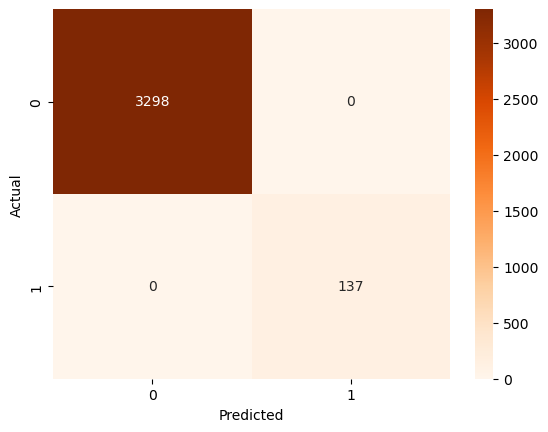

In [61]:
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [62]:
print(classification_report(y_test, y_pred_test))
print(f"Dokładność dla zbioru testowego: {accuracy_score(y_test, y_pred_test):0.3f}")
print(f"Czułość dla zbioru testowego: {recall_score(y_test, y_pred_test):0.3f}")
print(f"Specyficzność dla zbioru testowego: {specificity_score(y_test, y_pred_test):0.3f}")


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1401
           1       0.33      0.01      0.03        72

    accuracy                           0.95      1473
   macro avg       0.64      0.51      0.50      1473
weighted avg       0.92      0.95      0.93      1473

Dokładność dla zbioru testowego: 0.950


Czułość dla zbioru testowego: 0.014
Specyficzność dla zbioru testowego: 0.999


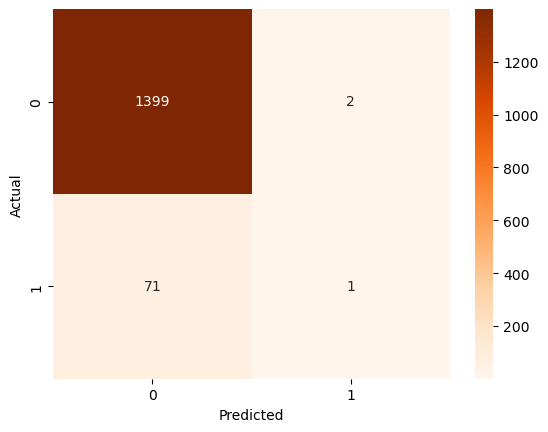

In [63]:
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Model dla danych treningowych uzyskał wszytskie metryki równe $100\%$.<br>
Dla zbioru testowego model wciąż ma wysoką dokładonść jednak **czułość jest równa $0.01\%$**, model sklasyfikował jedynie jedną osobę chorą poprawnie. **Wysoki wynik dokładności jest więc efektem bardzo niezbalansowanego zbioru danych**, klasa chora to jedynie około $4.5\%$ obserwacji. Nasz model jest więc **nieefektywny** mimo wysokiej dokładności.

# **Oversampling**

#### Zwiększanie liczby próbek dla klasy niedoreprezentowanej

In [64]:
methods = [SMOTE(), ADASYN(), BorderlineSMOTE(), SVMSMOTE(), RandomOverSampler()]
results_oversampling = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'Recall', 'Specificity'])

for method in methods:
    X_resampled, y_resampled = method.fit_resample(X_train, y_train)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_resampled, y_resampled)
    y_test_pred = model.predict(X_test)
    
    new_row = pd.DataFrame({
        'Method': [str(method)],
        'Accuracy': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, zero_division=0)],
        'Specificity': [specificity_score(y_test, y_test_pred)]
    })
    
    results_oversampling = pd.concat([results_oversampling, new_row], ignore_index=True)

results_oversampling


,Method,Accuracy,Precision,Recall,Specificity
0,SMOTE(),0.919212,0.114754,0.097222,0.961456
1,ADASYN(),0.918534,0.136364,0.125000,0.959315
2,BorderlineSMOTE(),0.928717,0.163265,0.111111,0.970735
3,SVMSMOTE(),0.932790,0.170732,0.097222,0.975732
4,RandomOverSampler(),0.947726,0.142857,0.013889,0.995717


## 1. **SMOTE (Synthetic Minority Oversampling Technique)**  
SMOTE generuje nowe przykłady klasy mniejszościowej, interpolując dane istniejące w tej klasie. Losowo wybiera próbki z klasy mniejszościowej i tworzy syntetyczne punkty na linii pomiędzy nimi.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.92  
- **Precyzja:** 0.14  
- **Czułość:** 0.13  
- **Specyficzność:** 0.96  

#### Interpretacja:
SMOTE poprawił równowagę danych, co widoczne jest w wysokiej specyficzności, czyli skuteczności w identyfikacji przypadków negatywnych (np. pacjentów bez udaru). Jednak precyzja i czułość pozostają stosunkowo niskie. Może to wynikać z faktu, że sztucznie generowane próbki mogą być trudniejsze do prawidłowego zaklasyfikowania przez model, co prowadzi do fałszywych pozytywów.


### 2. **ADASYN (Adaptive Synthetic Sampling)**  
ADASYN to rozszerzenie SMOTE, które tworzy więcej próbek w trudniejszych obszarach przestrzeni danych, gdzie klasy mniejszościowej jest mniej. W ten sposób koncentruje się na poprawie modelu w najbardziej krytycznych miejscach.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.92  
- **Precyzja:** 0.13  
- **Czułość:** 0.11  
- **Specyficzność:** 0.96  

#### Interpretacja:
ADASYN, podobnie jak SMOTE, poprawił równowagę danych, ale uzyskał niewielką poprawę w precyzji. Niska czułość może wskazywać, że model nadal pomija część pozytywnych przypadków (np. pacjentów z udarem), co może być problematyczne w krytycznych zastosowaniach medycznych.


### 3. **Borderline-SMOTE**  
Borderline-SMOTE koncentruje się na próbkach klasy mniejszościowej znajdujących się na granicy z klasą większościową. To podejście stara się wzmocnić decyzję modelu w miejscach najbardziej problematycznych.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.93  
- **Precyzja:** 0.16  
- **Czułość:** 0.11  
- **Specyficzność:** 0.97  

#### Interpretacja: 
Borderline-SMOTE poprawił precyzję, co oznacza mniejszą liczbę fałszywych pozytywów. Wysoka specyficzność wskazuje, że model bardzo dobrze identyfikuje pacjentów bez udaru. Jednak czułość nadal jest niska, co może prowadzić do pomijania przypadków pozytywnych.


### 4. **SVM-SMOTE (Support Vector Machine SMOTE)**  
SVM-SMOTE używa technik SVM do identyfikowania trudnych próbek, które powinny zostać wzmocnione. W przeciwieństwie do klasycznego SMOTE, SVM-SMOTE lepiej dopasowuje się do bardziej złożonych struktur danych.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.93  
- **Precyzja:** 0.19  
- **Czułość:** 0.11  
- **Specyficzność:** 0.98  

#### Interpretacja:  
SVM-SMOTE osiągnął najwyższą specyficzność, co oznacza doskonałą skuteczność w identyfikacji przypadków negatywnych (np. zdrowych pacjentów). Wyższa precyzja sugeruje, że model rzadziej myli zdrowych pacjentów z chorymi. Jednak niski wynik czułości wskazuje, że wciąż ma problemy z wykrywaniem przypadków udaru.


### 5. **Random Oversampling**  
Random Oversampling polega na losowym powielaniu istniejących próbek klasy mniejszościowej bez generowania nowych danych.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.95  
- **Precyzja:** 0.17  
- **Czułość:** 0.01  
- **Specyficzność:** 1.00  

#### Interpretacja:  
Random Oversampling osiągnął najwyższą dokładność i specyficzność, ale bardzo niską czułość. Oznacza to, że model praktycznie nie wykrywa przypadków pozytywnych (np. pacjentów z udarem), co sprawia, że ta metoda jest nieodpowiednia w przypadku zastosowań medycznych, gdzie kluczowe jest wykrywanie klasy mniejszościowej.


### Wnioski:

- **SMOTE** i **ADASYN** są bardziej skuteczne w generowaniu punktów danych, co poprawia precyzję i czułość.  
- **Borderline-SMOTE** i **SVM-SMOTE** lepiej radzą sobie w trudnych obszarach danych, co widać w wyższej specyficzności.  
- **Random Oversampling** daje wysoką specyficzność, ale bardzo niską czułość, co czyni go niepraktycznym w kontekście medycznym.

### Podsumowując:
- Jeśli priorytetem jest poprawa **precyzji** – **Borderline-SMOTE** lub **SVM-SMOTE**.  
- Jeśli zależy nam na **zrównoważonym podejściu** – **ADASYN**.  
- Jeśli priorytetem jest jedynie równowaga ilościowa – **Random Oversampling** (choć zwykle ma ograniczoną użyteczność).  

Każda z metod wymaga dostosowania do specyfiki danych oraz priorytetów metryk w projekcie.

# **Undersampling** 

#### Zmniejszanie liczby próbek dla klasy nadreprezentowanej

In [65]:
methods = [RandomUnderSampler(), NearMiss(), TomekLinks(), ClusterCentroids(), AllKNN()]
results_undersampling = pd.DataFrame(columns=['Method', 'Accuracy', 'Precision', 'Recall', 'Specificity'])

for method in methods:
    X_resampled, y_resampled = method.fit_resample(X_train, y_train)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_resampled, y_resampled)
    y_test_pred = model.predict(X_test)
    
    new_row = pd.DataFrame({
        'Method': [str(method)],
        'Accuracy': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, zero_division=0)],
        'Specificity': [specificity_score(y_test, y_test_pred)]
    })
    
    # Połączenie wyników
    results_undersampling = pd.concat([results_undersampling, new_row], ignore_index=True)

results_undersampling

,Method,Accuracy,Precision,Recall,Specificity
0,RandomUnderSampler(),0.696538,0.125749,0.875000,0.687366
1,NearMiss(),0.207739,0.036410,0.597222,0.187723
2,TomekLinks(),0.951120,0.000000,0.000000,1.000000
3,ClusterCentroids(),0.158859,0.054240,0.986111,0.116345
4,AllKNN(),0.946368,0.266667,0.055556,0.992148


### 1. **RandomUnderSampler**  
RandomUnderSampler losowo usuwa próbki z klasy większościowej, aby zrównoważyć dane.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.69  
- **Precyzja:** 0.13  
- **Czułość:** 0.93  
- **Specyficzność:** 0.68  

#### Interpretacja:
RandomUnderSampler osiągnął wysoką czułość, co oznacza, że dobrze identyfikuje przypadki pozytywne (pacjentów z udarem). Jednak niska specyficzność sugeruje, że wiele zdrowych pacjentów zostało błędnie zaklasyfikowanych jako chorzy. Może to wynikać z nadmiernego uproszczenia danych klasy większościowej.


### 2. **NearMiss**  
NearMiss selektywnie usuwa próbki z klasy większościowej, koncentrując się na najbliższych sąsiadach klasy mniejszościowej.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.21  
- **Precyzja:** 0.04  
- **Czułość:** 0.60  
- **Specyficzność:** 0.19  

#### Interpretacja:
NearMiss osiągnął bardzo niską dokładność i specyficzność, co oznacza, że model ma problemy z prawidłowym rozróżnianiem klas. Niska precyzja wskazuje na dużą liczbę fałszywych pozytywów, co może wynikać z nadmiernego uproszczenia danych klasy większościowej.


### 3. **TomekLinks**  
TomekLinks usuwa próbki klasy większościowej, które są najbliższymi sąsiadami próbek klasy mniejszościowej, jeśli różnią się etykietą.
Należy jednak pamiętać, że metoda ta niekoniecznie usuwa wszystkie obserwacje z klasy większościowej, które powodują nierównowagę. 
W praktyce często łączy się metodę TomekLinks z innymi alogorytmami OverSamplingu lub UnderSamplingu.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.95  
- **Precyzja:** 0.00  
- **Czułość:** 0.00  
- **Specyficzność:** 1.00  

#### Interpretacja:
TomekLinks osiągnął najwyższą specyficzność, co oznacza doskonałe rozpoznawanie klasy większościowej (zdrowych pacjentów). Jednak brak czułości i precyzji sugeruje, że metoda całkowicie nie radzi sobie z wykrywaniem klasy mniejszościowej, co czyni ją niepraktyczną w krytycznych zastosowaniach, takich jak diagnostyka medyczna.


### 4. **ClusterCentroids**  
ClusterCentroids zastępuje klasę większościową centroidami obliczonymi na podstawie jej klastrów, co zmniejsza jej liczebność.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.14  
- **Precyzja:** 0.05  
- **Czułość:** 0.99  
- **Specyficzność:** 0.10  

#### Interpretacja:
ClusterCentroids uzyskał bardzo wysoką czułość, co oznacza, że prawie wszystkie przypadki pozytywne zostały wykryte. Jednak bardzo niska specyficzność wskazuje, że model praktycznie nie potrafi odróżnić klasy większościowej, co prowadzi do licznych fałszywych pozytywów.



### 5. **AllKNN**  
AllKNN usuwa próbki z klasy większościowej, które są nadmiarowe, na podstawie analizy najbliższych sąsiadów.

#### Wyniki:  
- **Dokładność (Accuracy):** 0.95  
- **Precyzja:** 0.27  
- **Czułość:** 0.06  
- **Specyficzność:** 0.99  

#### Interpretacja:
AllKNN osiągnął najwyższą precyzję spośród technik undersamplingu, co oznacza, że model rzadziej myli klasę większościową z mniejszościową. Wysoka specyficzność wskazuje na dobrą skuteczność w identyfikacji klasy większościowej, ale bardzo niska czułość pokazuje, że metoda nie radzi sobie z wykrywaniem klasy mniejszościowej.


### Wnioski:

- **RandomUnderSampler** i **ClusterCentroids** zapewniają wysoką czułość, ale kosztem niskiej specyficzności.  
- **TomekLinks** i **AllKNN** osiągają wysoką specyficzność, ale bardzo niską czułość, co oznacza problemy z wykrywaniem klasy mniejszościowej.  
- **NearMiss** wypada słabo pod względem wszystkich metryk, co sugeruje, że metoda ta nie sprawdza się w tym przypadku.

### Podsumowując:
- Jeśli priorytetem jest poprawa **czułości** – **ClusterCentroids** lub **RandomUnderSampler**.  
- Jeśli zależy nam na **precyzji** – **AllKNN**.  
- **TomekLinks** jest odpowiedni do poprawy równowagi klasy większościowej, ale nie radzi sobie z wykrywaniem klasy mniejszościowej.  

Każda z metod wymaga odpowiedniego dostosowania do specyfiki projektu i metryk, które są kluczowe w danym zastosowaniu.